In [4]:
from IPython.display import Image, HTML
Image(url='https://s3.amazonaws.com/drivendata-public-assets/nepal-quake-bm-2.JPG')

In [5]:
# Create DataFrame
import pandas as pd

# Math transformations
import numpy as np
import math

# Data Viz
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot, plot

# Stats
from scipy import stats
from scipy.stats import randint

# Train test split
from sklearn.model_selection import train_test_split

# Feature engineering
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, scale
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

# Machine Learning
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Fine-tune
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.model_selection import GridSearchCV, validation_curve, StratifiedKFold

In [6]:
features = pd.read_csv('https://s3.amazonaws.com/drivendata/data/57/public/train_values.csv').set_index('building_id')
target = pd.read_csv('https://s3.amazonaws.com/drivendata/data/57/public/train_labels.csv').set_index('building_id')

In [7]:
df=pd.concat([features,target],axis=1)
display(HTML('<h3>A picture from aggregated DataFrame:</h3> <br>'))
display(df.head())

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
building_id,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,3
28830,8,900,2812,2,10,8,7,o,r,n,...,0,0,0,0,0,0,0,0,0,2
94947,21,363,8973,2,10,5,5,t,r,n,...,0,0,0,0,0,0,0,0,0,3
590882,22,418,10694,2,10,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,2
201944,11,131,1488,3,30,8,9,t,r,n,...,0,0,0,0,0,0,0,0,0,3


In [8]:
display(HTML('<h4>Memory usage of each attribute in megabytes:</h4><br>'))
df.memory_usage(deep=True)/(10**6)

Index                                      2.084808
geo_level_1_id                             2.084808
geo_level_2_id                             2.084808
geo_level_3_id                             2.084808
count_floors_pre_eq                        2.084808
age                                        2.084808
area_percentage                            2.084808
height_percentage                          2.084808
land_surface_condition                    15.114858
foundation_type                           15.114858
roof_type                                 15.114858
ground_floor_type                         15.114858
other_floor_type                          15.114858
position                                  15.114858
plan_configuration                        15.114858
has_superstructure_adobe_mud               2.084808
has_superstructure_mud_mortar_stone        2.084808
has_superstructure_stone_flag              2.084808
has_superstructure_cement_mortar_stone     2.084808
has_superstr

In [9]:
display(HTML(f'<h4>Shape of the data: {df.shape}</h4>'))

In [10]:
eda,_ = train_test_split(df, test_size=.2, random_state=42)

In [11]:
# This transformation needs in order to avoid confusion of damage_grade variable as continous
pd.set_option('mode.chained_assignment', None)
eda['damage_grade(eda)'] = np.where(eda.damage_grade==1,'(1) Low', 
                                    np.where(eda.damage_grade==2,'(2) Medium', 
                                             np.where(eda.damage_grade==3,'(3) High',0)))

In [12]:
fig = px.pie(eda.groupby('damage_grade(eda)').age.count().reset_index(), values='age', names='damage_grade(eda)' , title='Damage Grade Distribution')
fig.show()

In [13]:
fig = px.bar(eda.groupby(['age','damage_grade(eda)']).roof_type.count().reset_index().rename(columns={'roof_type':'count'}),
             x="age", y="count", color="damage_grade(eda)", title="Check if the age of the building affect on damage due to earthquake?")
fig.update_xaxes(range=[0, 100])
fig.show()

In [14]:
def draw_subplotted_pie_chart(eda ,col, labels, target_col):
    pd.set_option('mode.chained_assignment', None)    

    fig = make_subplots(rows=1, cols=4, specs=[[{'type':'domain'}, 
                                                {'type':'domain'},
                                                {'type':'domain'},
                                                {'type':'domain'}]], subplot_titles = labels)
    for i,lb in enumerate(labels):
        eda_labeled = eda[eda[target_col]==lb]
        eda_counted = pd.DataFrame(eda_labeled.groupby(col)[col].count()).rename(columns={
            col:'Count'}).reset_index()
        fig.add_trace(go.Pie(values=eda_counted.Count, labels=eda_counted[col], name=lb),1,i+1)
    fig.update_layout(title_text=f'{col} distribution for each {target_col}')
    iplot(fig)

labels=['0-10','10-15','15-30','30-995']
eda['age_cut']=pd.qcut(eda.age,4,labels=labels)
draw_subplotted_pie_chart(eda,'damage_grade(eda)',labels, 'age_cut')

Text(0.5, 1.0, 'Area Percentage')

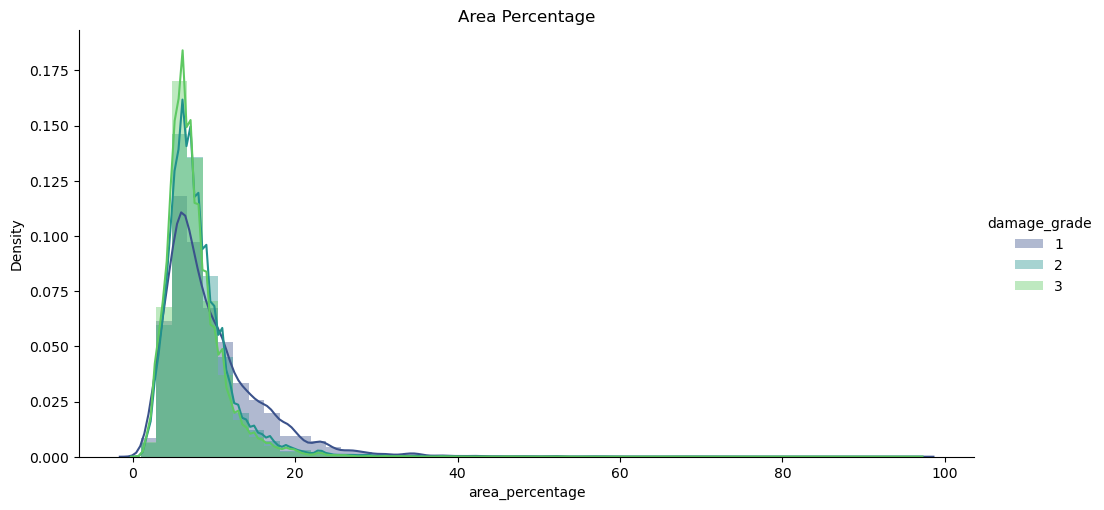

In [15]:
import warnings
warnings.filterwarnings('ignore')
sns.FacetGrid(eda,hue='damage_grade',height=5,aspect=2,palette="viridis")\
    .map(sns.distplot,'area_percentage')\
    .add_legend()
plt.title("Area Percentage")

<Axes: >

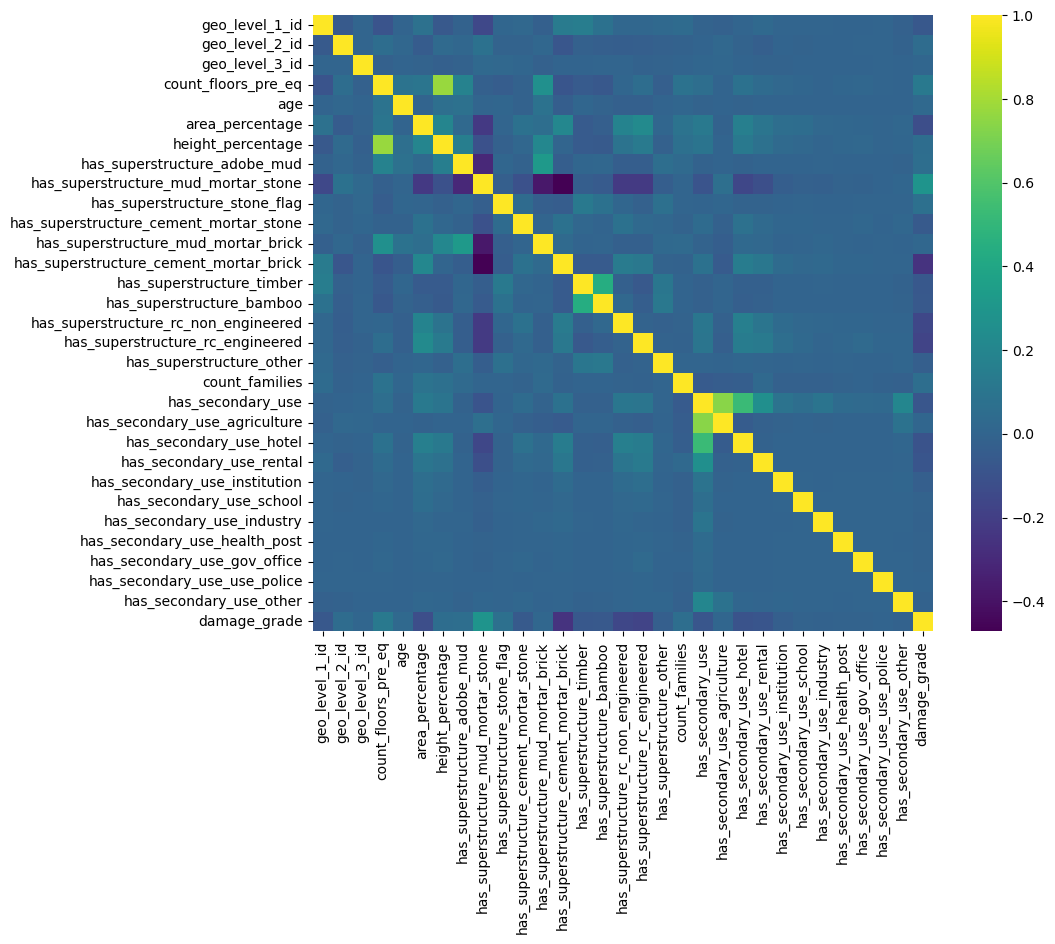

In [16]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
cor=eda.corr()
cor=pd.DataFrame(cor)
sns.heatmap(cor,cmap="viridis",ax=ax)

In [19]:
df_pre = df.reset_index().copy()

# Select data from datatype of each attr which is other than numbers and apply encoder
df_enc=df_pre.select_dtypes(exclude=["number"])
enc = OneHotEncoder(sparse=False,dtype=np.int64)
enc_matrix=enc.fit_transform(df_enc)

# Concat the encoded matrix with the other ones
df_basic = pd.concat([pd.DataFrame(enc_matrix, 
                                   columns=enc.get_feature_names_out(list(df_enc))),
                      df_pre],
                     axis=1).drop(list(df_enc), axis=1)

# Divide dataset by target and feature variables
y = df_basic.loc[:,'damage_grade']
X = df_basic.drop(['damage_grade','building_id'], axis=1)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None, stratify=y, shuffle=True)
cv = StratifiedKFold(n_splits=5, random_state=None)

In [27]:
dt = DecisionTreeClassifier(random_state=42)
cvs_res=cross_val_score(dt, X, y, cv=cv, scoring="accuracy", n_jobs=-1, verbose=5)
print(f'\nCross validated accuracy scores: {cvs_res}\n\n')
dt.fit(X_train, y_train)

dt_predictions=dt.predict(X_test)
print(f'accuracy_score: {accuracy_score(y_test, dt_predictions)}\n\n')
print(classification_report(y_test, dt_predictions))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.8s remaining:   13.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.2s finished



Cross validated accuracy scores: [0.65787303 0.65235994 0.65813507 0.65857636 0.65602456]


accuracy_score: 0.6563189501352622


              precision    recall  f1-score   support

           1       0.49      0.50      0.49      5025
           2       0.71      0.71      0.71     29652
           3       0.61      0.61      0.61     17444

    accuracy                           0.66     52121
   macro avg       0.60      0.61      0.61     52121
weighted avg       0.66      0.66      0.66     52121



In [28]:
%%time
param_dist = {
              "max_depth": np.linspace(75,125,5, dtype=np.int64),
              "max_leaf_nodes": np.linspace(2000,2500,10, dtype=np.int64),
    
}
tree_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), param_dist, cv=5, n_jobs=-1, verbose=10)
tree_cv.fit(X,y)
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END ................................ score: (test=0.658) total time=   6.9s
[CV 3/5; 1/50] START max_depth=75, max_leaf_nodes=2000..........................
[CV 3/5; 1/50] END max_depth=75, max_leaf_nodes=2000;, score=0.722 total time=   6.2s
[CV 5/5; 1/50] START max_depth=75, max_leaf_nodes=2000..........................
[CV 5/5; 1/50] END max_depth=75, max_leaf_nodes=2000;, score=0.721 total time=   6.4s
[CV 2/5; 3/50] START max_depth=75, max_leaf_nodes=2111..........................
[CV 2/5; 3/50] END max_depth=75, max_leaf_nodes=2111;, score=0.715 total time=   6.3s
[CV 3/5; 3/50] START max_depth=75, max_leaf_nodes=2111..........................
[CV 3/5; 3/50] END max_depth=75, max_leaf_nodes=2111;, score=0.721 total time=   6.8s
[CV 3/5; 4/50] START max_depth=75, max_leaf_nodes=2166..........................
[CV 3/5; 4/50] END max_depth=75, max_leaf_nodes=2166;, score=0.721 total time=   6.3s
[CV 2/5; 5/50] START m

In [29]:
def plot_cm(cf_matrix, save=False):
    labels=['Grade 1','Grade 2','Grade 3']
    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, xticklabels=labels, yticklabels=labels,
            fmt='.2%')
    if save:
        plt.savefig('best_dt_conf.png')

accuracy_score: 0.7176378043399014


              precision    recall  f1-score   support

           1       0.62      0.43      0.51      5025
           2       0.73      0.82      0.77     29652
           3       0.72      0.62      0.67     17444

    accuracy                           0.72     52121
   macro avg       0.69      0.63      0.65     52121
weighted avg       0.71      0.72      0.71     52121



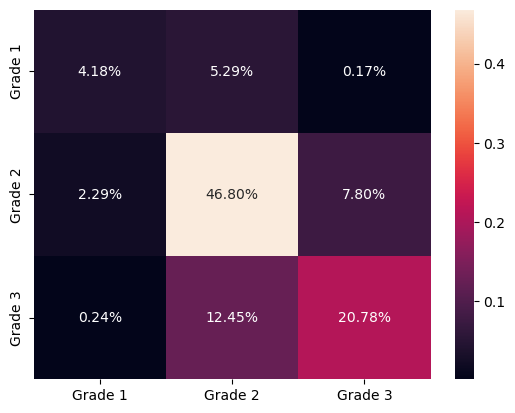

In [30]:
dt_best = DecisionTreeClassifier(max_depth=75, max_leaf_nodes=2333, random_state=42)
dt_best.fit(X_train,y_train)
dt_predictions=dt_best.predict(X_test)
print(f'accuracy_score: {accuracy_score(y_test, dt_predictions)}\n\n')
print(classification_report(y_test, dt_predictions))
cf_matrix = confusion_matrix(y_test, dt_predictions)
plot_cm(cf_matrix)

In [31]:
%%time
rf = RandomForestClassifier(random_state=42, n_jobs=-1, oob_score=True)
rf.fit(X_train, y_train)

cvs_res=cross_val_score(rf, X, y, cv=cv, scoring="accuracy", n_jobs=-1, verbose=5)
print(f'\nCross validated accuracy scores: {cvs_res}\n\n')

rf_predictions=rf.predict(X_test)
print(f'\naccuracy_score: {accuracy_score(y_test, rf_predictions)}\n\n')
print(classification_report(y_test, rf_predictions))


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.1min remaining:  3.1min


[CV 2/5; 39/50] END max_depth=112, max_leaf_nodes=2444;, score=0.715 total time=   7.0s
[CV 1/5; 40/50] START max_depth=112, max_leaf_nodes=2500........................
[CV 1/5; 40/50] END max_depth=112, max_leaf_nodes=2500;, score=0.718 total time=   6.5s
[CV 5/5; 40/50] START max_depth=112, max_leaf_nodes=2500........................
[CV 5/5; 40/50] END max_depth=112, max_leaf_nodes=2500;, score=0.720 total time=   6.6s
[CV 4/5; 41/50] START max_depth=125, max_leaf_nodes=2000........................
[CV 4/5; 41/50] END max_depth=125, max_leaf_nodes=2000;, score=0.719 total time=   6.3s
[CV 3/5; 42/50] START max_depth=125, max_leaf_nodes=2055........................
[CV 3/5; 42/50] END max_depth=125, max_leaf_nodes=2055;, score=0.721 total time=   6.3s
[CV 2/5; 43/50] START max_depth=125, max_leaf_nodes=2111........................
[CV 2/5; 43/50] END max_depth=125, max_leaf_nodes=2111;, score=0.715 total time=   6.6s
[CV 5/5; 43/50] START max_depth=125, max_leaf_nodes=2111...........

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.7min finished



Cross validated accuracy scores: [0.71195871 0.7102264  0.7151957  0.71636608 0.71329624]


[CV 5/5; 39/50] START max_depth=112, max_leaf_nodes=2444........................
[CV 5/5; 39/50] END max_depth=112, max_leaf_nodes=2444;, score=0.721 total time=   6.7s
[CV 4/5; 40/50] START max_depth=112, max_leaf_nodes=2500........................
[CV 4/5; 40/50] END max_depth=112, max_leaf_nodes=2500;, score=0.719 total time=   6.7s
[CV 3/5; 41/50] START max_depth=125, max_leaf_nodes=2000........................
[CV 3/5; 41/50] END max_depth=125, max_leaf_nodes=2000;, score=0.722 total time=   6.4s
[CV 2/5; 42/50] START max_depth=125, max_leaf_nodes=2055........................
[CV 2/5; 42/50] END max_depth=125, max_leaf_nodes=2055;, score=0.715 total time=   6.4s
[CV 1/5; 43/50] START max_depth=125, max_leaf_nodes=2111........................
[CV 1/5; 43/50] END max_depth=125, max_leaf_nodes=2111;, score=0.718 total time=   7.0s
[CV 1/5; 44/50] START max_depth=125, max_leaf_nodes=2166......

In [32]:
def plot_oob(acc,oob,parameters):
    rf_best_oob=pd.DataFrame(parameters,columns=['Number of Tree'])
    rf_best_oob['Accuracy Score'],rf_best_oob['Out-of-bag Score'] = acc,oob
    dd=rf_best_oob[['Accuracy Score','Out-of-bag Score']].stack().reset_index().rename({'level_0':'Number of Tree',
                                                                                        'level_1':'Score Type',
                                                                                        0:'Score'},axis=1)
    dd=dd.replace({'Number of Tree':{key:value for (key,
                                                    value) in zip(np.arange(0,6,1),
                                                                  rf_best_oob[['Number of Tree']].values)}})
    fig=px.line(dd, x='Number of Tree', y='Score', color='Score Type', labels={'index':'Fold ID'})
    fig.update_xaxes(type='category')
    fig.show()

In [33]:
%%time
acc,oob=[],[]
for i in [10, 100, 300, 500, 700, 900]:
    rf = RandomForestClassifier(n_estimators=i, random_state=42, n_jobs=-1, oob_score=True,verbose=1)
    rf.fit(X_train, y_train)
    rf_predictions=rf.predict(X_test)
    acc.append(accuracy_score(y_test, rf_predictions))
    oob.append(rf.oob_score_)

# Plot
plot_oob(acc,oob,[10, 100, 300, 500, 700, 900])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   26.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   50.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.3min finish

[CV 3/5; 39/50] START max_depth=112, max_leaf_nodes=2444........................
[CV 3/5; 39/50] END max_depth=112, max_leaf_nodes=2444;, score=0.721 total time=   6.2s
[CV 2/5; 40/50] START max_depth=112, max_leaf_nodes=2500........................
[CV 2/5; 40/50] END max_depth=112, max_leaf_nodes=2500;, score=0.715 total time=   6.4s
[CV 1/5; 41/50] START max_depth=125, max_leaf_nodes=2000........................
[CV 1/5; 41/50] END max_depth=125, max_leaf_nodes=2000;, score=0.719 total time=   6.3s
[CV 5/5; 41/50] START max_depth=125, max_leaf_nodes=2000........................
[CV 5/5; 41/50] END max_depth=125, max_leaf_nodes=2000;, score=0.721 total time=   6.4s
[CV 4/5; 42/50] START max_depth=125, max_leaf_nodes=2055........................
[CV 4/5; 42/50] END max_depth=125, max_leaf_nodes=2055;, score=0.719 total time=   6.9s
[CV 3/5; 43/50] START max_depth=125, max_leaf_nodes=2111........................
[CV 3/5; 43/50] END max_depth=125, max_leaf_nodes=2111;, score=0.721 total

[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    5.5s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    6.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   53.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:  3.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   

CPU times: user 47min 34s, sys: 20.8 s, total: 47min 55s
Wall time: 14min 34s


accuracy_score: 0.712284875577982


              precision    recall  f1-score   support

           1       0.64      0.47      0.54      5025
           2       0.72      0.82      0.77     29652
           3       0.71      0.60      0.65     17444

    accuracy                           0.71     52121
   macro avg       0.69      0.63      0.65     52121
weighted avg       0.71      0.71      0.71     52121

CPU times: user 1min 8s, sys: 1.47 s, total: 1min 9s
Wall time: 1min 9s


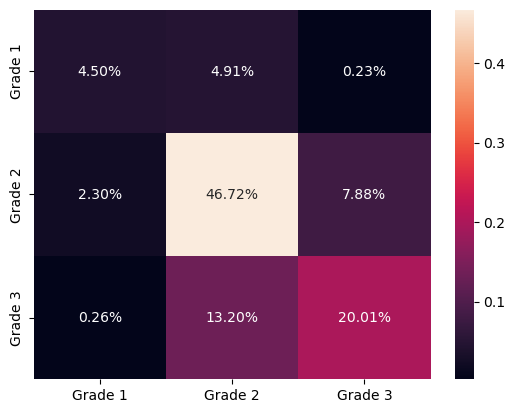

In [34]:
%%time
rf_best = RandomForestClassifier(n_estimators=100, random_state=42)
rf_best.fit(X_train,y_train)
rf_predictions=rf_best.predict(X_test)
print(f'accuracy_score: {accuracy_score(y_test, rf_predictions)}\n\n')
print(classification_report(y_test, rf_predictions))
cf_matrix = confusion_matrix(y_test, rf_predictions)
plot_cm(cf_matrix)

In [35]:
%%time
dt_f = DecisionTreeClassifier(random_state = 24, max_depth=75, max_leaf_nodes=2333)
dt_f.fit(X_train,y_train)
dt_f_pred=dt_f.predict(X_test)

rf_f = RandomForestClassifier(n_estimators=100, random_state = 24)
rf_f.fit(X_train,y_train)
rf_f_pred=rf_f.predict(X_test)

# Classification Report
display(HTML('<h4>Decision Trees Classification Report</h4>'))
print(classification_report(y_test, dt_f_pred))
display(HTML('<h4>Random Forest Classification Report</h4>'))
print(classification_report(y_test, rf_f_pred))

#Confusion Matrix
cm_dt=confusion_matrix(y_test,dt_f_pred)
conf_matrix_dt=pd.DataFrame(data=cm_dt,columns=['Predicted:1','Predicted:2','Predicted:3'],
                                         index=['Actual:1','Actual:2','Actual:3'])
cm_rf=confusion_matrix(y_test,rf_f_pred)
conf_matrix_rf=pd.DataFrame(data=cm_rf,columns=['Predicted:1','Predicted:2','Predicted:3'],
                                         index=['Actual:1','Actual:2','Actual:3'])

              precision    recall  f1-score   support

           1       0.62      0.43      0.51      5025
           2       0.73      0.82      0.77     29652
           3       0.72      0.62      0.67     17444

    accuracy                           0.72     52121
   macro avg       0.69      0.63      0.65     52121
weighted avg       0.71      0.72      0.71     52121



              precision    recall  f1-score   support

           1       0.64      0.46      0.54      5025
           2       0.72      0.82      0.77     29652
           3       0.71      0.60      0.65     17444

    accuracy                           0.71     52121
   macro avg       0.69      0.63      0.65     52121
weighted avg       0.71      0.71      0.71     52121

CPU times: user 1min 14s, sys: 1.61 s, total: 1min 16s
Wall time: 1min 16s


<Axes: >

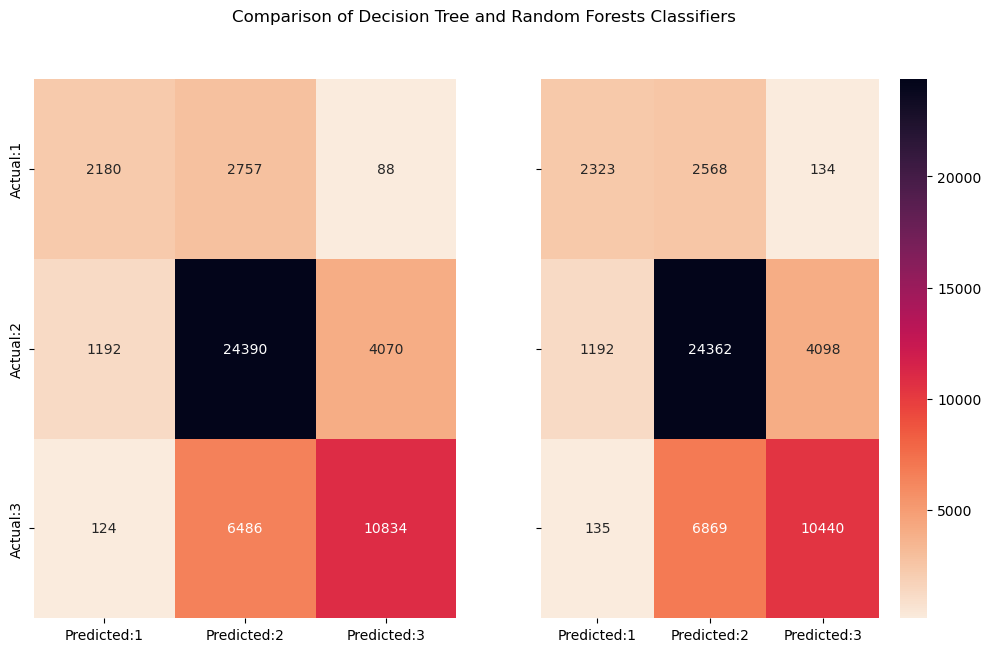

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,7), sharey=True)
fig.suptitle('Comparison of Decision Tree and Random Forests Classifiers')
sns.heatmap(conf_matrix_dt, annot=True,fmt='d',cmap="rocket_r",ax=ax1, cbar=False)
sns.heatmap(conf_matrix_rf, annot=True,fmt='d',cmap="rocket_r",ax=ax2)